<a href="https://colab.research.google.com/github/SamH3pn3r/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [2]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=549.2086944767983, mobile=False), User(purchased=False, time_on_site=82.98505220806115, mobile=True), User(purchased=False, time_on_site=10.37999853491663, mobile=True), User(purchased=False, time_on_site=199.6635856294555, mobile=False), User(purchased=True, time_on_site=173.96159043738047, mobile=True), User(purchased=False, time_on_site=476.70047926838197, mobile=False), User(purchased=True, time_on_site=214.8372069003409, mobile=True), User(purchased=False, time_on_site=201.7531121218215, mobile=True), User(purchased=True, time_on_site=216.24666554886988, mobile=True), User(purchased=True, time_on_site=193.45734427946596, mobile=True)]


In [0]:
!pip freeze

In [10]:
!pip install pandas==0.23.4

     |████████████████████████████████| 8.9MB 4.7MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=0.24.0, but you'll have pandas 0.23.4 which is incompatible.
  Found existing installation: pandas 0.24.2
    Uninstalling pandas-0.24.2:
      Successfully uninstalled pandas-0.24.2


In [6]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head(20)

,purchased,time_on_site,mobile
0,True,549.208694,False
1,False,82.985052,True
2,False,10.379999,True
3,False,199.663586,False
4,True,173.961590,True
5,False,476.700479,False
6,True,214.837207,True
7,False,201.753112,True
8,True,216.246666,True
9,True,193.457344,True


In [7]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.088827808775765,5.219876602394463,5.49623133621817,5.921862805297637,6.674642225763021,6.866432168297793,6.89136154701731,6.952817320994936,7.252053471157675,7.715721051931856,8.391348423334183,8.42570338745352,8.684955680181227,8.904959518439453,9.129811608213394,9.432163033082844,9.728000571513062,9.824961590203838,10.37999853491663,10.733527022350387,11.86253555432961,11.879424643431275,12.055758013905177,12.13392530382459,12.283514568255384,12.380177500433296,12.695576824663542,12.96032637936894,12.977136660546991,13.453799675056413,13.882151199190972,14.436561350625547,14.5836938389272,14.640776890740598,14.939230496458585,15.27668891406826,16.420343561358248,16.78698499348276,17.43232936591315,17.63819205537918,...,489.5699564675082,492.3391485253717,493.66279097749697,495.3543034705803,496.90486198150177,502.03903122428704,503.2126206882664,505.74831255240485,509.12286112156823,509.34166936739643,510.8343138937771,512.784070849736,521.3147792306761,521.9308374775711,529.6647086058108,532.9869107309889,537.7525653659756,540.5879000310795,544.7813910999105,545.7463602209443,549.2086944767983,555.1194571688732,555.6885527293224,556.4284062421301,559.5469392187073,564.6245612560587,572.1470735663605,573.1207127204697,576.928491001582,580.2422689523536,580.920640516344,583.29473499356,583.5702559653394,583.9776930058396,587.3657333669496,588.2227725611015,594.0035307689654,594.7239078996153,598.0667169797609,599.8007965203186
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,1,1,1,0,0,1,1,1,1,1,0,1,1,0,...,1,1,0,1,1,0,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0
True,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,0,1,1,1,0,0,1,1,0,1,0,1,1,1,1,1,1,1,0,0,1


In [8]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.494, 124.031]","(124.031, 242.974]","(242.974, 361.916]","(361.916, 480.858]","(480.858, 599.801]"
purchased,,,,,
False,244,220,86,30,21
True,108,160,87,20,24


In [10]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.494, 124.031]","(124.031, 242.974]","(242.974, 361.916]","(361.916, 480.858]","(480.858, 599.801]"
purchased,,,,,
False,0.693182,0.578947,0.49711,0.6,0.466667
True,0.306818,0.421053,0.50289,0.4,0.533333


In [11]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.684,0.573333
True,0.316,0.426667


In [18]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], normalize='index')
ct

purchased               False        ...                      True 
time_on_site (4.494, 124.031]        ...         (480.858, 599.801]
mobile                               ...                           
False                0.216000        ...                      0.096
True                 0.253333        ...                      0.000

[2 rows x 10 columns]

In [19]:
type(ct)

pandas.core.frame.DataFrame

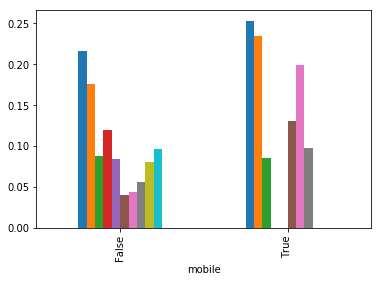

In [25]:
ct.plot(kind='bar', legend=False);

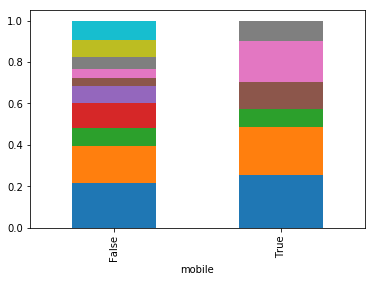

In [26]:
ct.plot(kind='bar',stacked=True, legend=False);

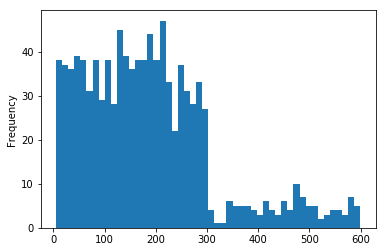

In [27]:
user_data['time_on_site'].plot.hist(bins=50);

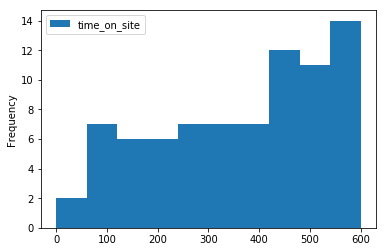

In [38]:
user_data[(user_data['mobile']==False) & (user_data['purchased']==True)].plot.hist();

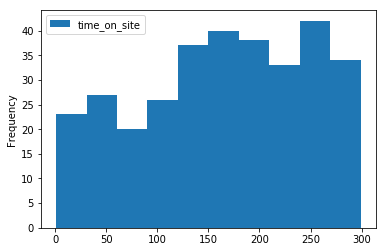

In [39]:
user_data[(user_data['mobile']==True) & (user_data['purchased']==True)].plot.hist();

In [40]:
pt = pd.pivot_table(user_data, values='purchased', index = time_bins)
pt

,purchased
time_on_site,
"(4.494, 124.031]",0.306818
"(124.031, 242.974]",0.421053
"(242.974, 361.916]",0.502890
"(361.916, 480.858]",0.400000
"(480.858, 599.801]",0.533333


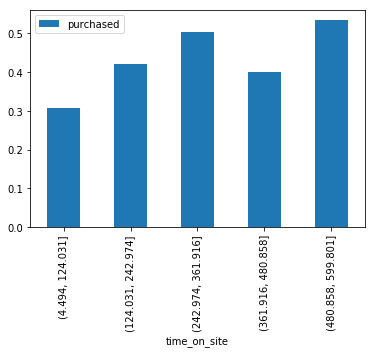

In [41]:
pt.plot.bar();

In [43]:
ct = pd.crosstab(time_bins,[user_data['purchased'], user_data['mobile']], normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.494, 124.031]    0.315789  0.441860  0.126582  0.306250
(124.031, 242.974]  0.257310  0.409302  0.139241  0.465625
(242.974, 361.916]  0.128655  0.148837  0.177215  0.228125
(361.916, 480.858]  0.175439  0.000000  0.253165  0.000000
(480.858, 599.801]  0.122807  0.000000  0.303797  0.000000

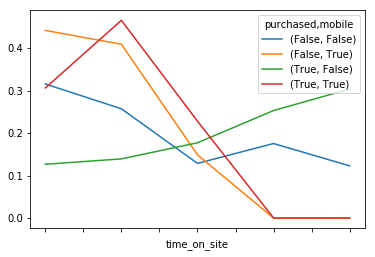

In [44]:
ct.plot();

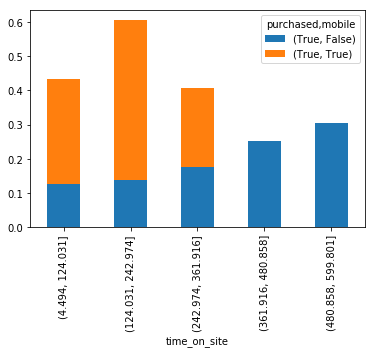

In [47]:
ct_sliced = ct.iloc[:,[2,3]]

ct_sliced.plot(kind='bar', stacked=True);

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [52]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
import pandas as pd
persons_data_url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv'

persons_data = pd.read_csv(persons_data_url)
persons_data.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [0]:
#deleting first column
persons_data = persons_data.drop(columns='Unnamed: 0')
persons_data

In [57]:
#find data types
persons_data.dtypes

Unnamed: 0       int64
age              int64
weight           int64
exercise_time    int64
dtype: object

In [0]:
weight_bins = pd.cut(persons_data['weight'], 7)
exercise_time_bins = pd.cut(persons_data['exercise_time'],7)
age_bins = pd.cut(persons_data['age'],7)

In [0]:
we = pd.crosstab(weight_bins,exercise_time_bins)
ae = pd.crosstab(age_bins,exercise_time_bins)
aw = pd.crosstab(age_bins, weight_bins)
ew = pd.crosstab(exercise_time_bins, weight_bins)

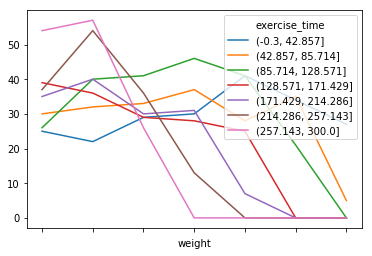

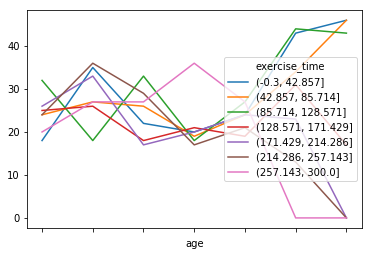

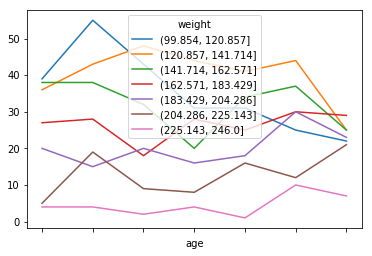

In [118]:
#first quick plots
we.plot();
ae.plot();
aw.plot();

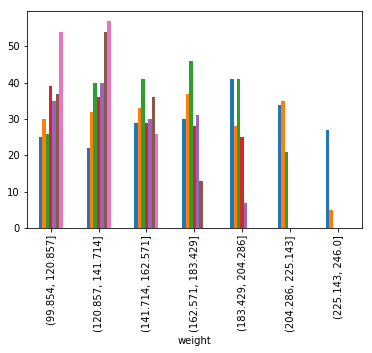

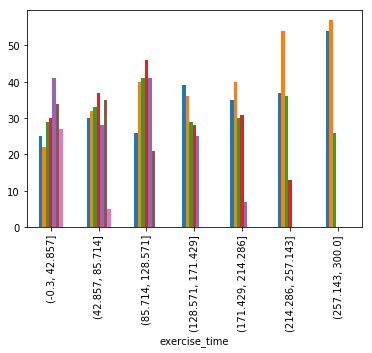

In [120]:
#plotting bar graphs with rotated x-axis labels
we.plot(kind='bar',legend = False);
ew.plot(kind='bar',legend=False);

In [142]:
all_three = pd.crosstab(weight_bins,[age_bins,exercise_time_bins], normalize='index')
all_three

age                (17.938, 26.857]        ...             (71.143, 80.0]
exercise_time        (-0.3, 42.857]        ...         (128.571, 171.429]
weight                                     ...                           
(99.854, 120.857]          0.008130        ...                   0.020325
(120.857, 141.714]         0.014235        ...                   0.010676
(141.714, 162.571]         0.004464        ...                   0.013393
(162.571, 183.429]         0.010811        ...                   0.016216
(183.429, 204.286]         0.028169        ...                   0.021127
(204.286, 225.143]         0.022222        ...                   0.000000
(225.143, 246.0]           0.093750        ...                   0.000000

[7 rows x 45 columns]

In [0]:
#selecting young people
all_three_young = all_three.iloc[:,[0,1,2,3,4,5,6]]

In [0]:
#selecting mid age people
all_three_mid = all_three.iloc[:,[7,8,9,10,11,12,13]]

In [0]:
#selecting older age people
all_three_old = all_three.iloc[:,[14,15,16,17,18,19,20]]

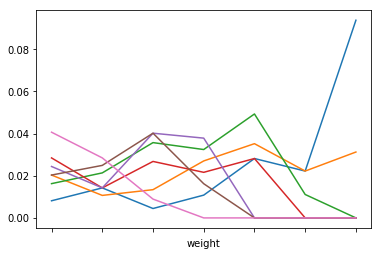

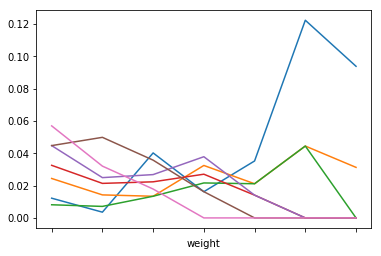

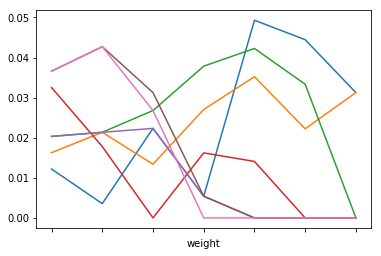

In [150]:
#displaying the three age groups separately
all_three_young.plot(legend=False);
all_three_mid.plot(legend=False);
all_three_old.plot(legend=False);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


1. All variables are integers.
2. As weight increases (across all ages), the number of people exercising for shorter period of time is increasing where longer periods of exercise time are decreasing.
3. Weight and exercise time are real relationships but age is spurious.


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)